# Flowers and triangles

This notebook attempts to visualize the melodic movement present in a collection of songs in two more unconventional ways.
As raster plots (melody flowers) and as ternary plots (melody triangles).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ternary
import h5py

from utils import split_at_nan, sliding_window, interval_motifs, normalize

In [2]:
# The directory with all catafolk data
CATAFOLK_DIR = '~/surfdrive/catafolk'

# The directory with all Tsimané transcriptions
TSIMANE_DIR = '~/repos/papers/tsimane/transcriptions/musicxml'

# The main data file
# DATA_STORE = '../data/test.hdf5'
DATA_STORE = '../data/data.hdf5'

# Settings and global variables
plt.rcParams['font.sans-serif'] = ['Arial', 'HelveticaNeue', 'Helvetica']

# Save figures?
SAVE = True

## Load data

In [3]:
with h5py.File(DATA_STORE, 'r') as file:
    CORPORA = [key for key in file.keys()]

In [4]:
def load_data(corpus, repeats=False):
    """Load the pitches and onsets for every entry in a corpus. The pitches and
    onsets are both lists of numpy arrays of equal length."""
    with h5py.File(DATA_STORE, 'r') as file:
        root = f"{corpus}/{'with' if repeats else 'without'}-repeats/"
        all_onsets = file[f'{root}/onsets'][:]
        all_pitches = file[f'{root}/pitches'][:]
        assert len(all_pitches) == len(all_onsets)

    if len(all_onsets) == 0: return [], []
    onsets = split_at_nan(all_onsets)
    pitches = split_at_nan(all_pitches)
    assert len(onsets) == len(pitches)
    return onsets, pitches

onsets, pitches = load_data(CORPORA[0])

## Melody flowers (raster plots)

In [5]:
def decorate_raster_plot(
        small_ax, large_ax, 
        small_color='C3', large_color='C0',
        large_label='larger interval',
        small_label='smaller interval',
    ):
    # Zero line
    small_ax.axvline(0, c='k', ls='--', lw=1)
    large_ax.axvline(0, c='k', ls='--', lw=1)

    # Ticks and labels
    large_ax.tick_params(axis='x', labelcolor=large_color)
    small_ax.tick_params(axis='x', labelcolor=small_color)
    
    # Labels
    large_ax.set_xlabel(large_label, color=large_color) 
    small_ax.set_xlabel(small_label, color=small_color) 

    # Format the spines
    for spine in ['top', 'bottom']:
        small_ax.spines[spine].set_color(small_color)
        small_ax.spines[spine].set_linewidth(2)
        large_ax.spines[spine].set_color(large_color)
        large_ax.spines[spine].set_linewidth(2)
    
    sns.despine(ax=small_ax, left=True, top=False)
    sns.despine(ax=large_ax, left=True, top=False)
    small_ax.set_yticks([])
    large_ax.set_yticks([])

In [6]:
def jitter_scatter(x, y, jitter=.1, **kwargs):
    _kwargs = dict(s=1, alpha=.5, ax=plt.gca(), lw=0)
    _kwargs.update(kwargs)
    ax = _kwargs.pop('ax')
    (xjit, yjit) = (jitter, jitter) if type(jitter) != tuple else jitter
    x += np.random.normal(0, xjit, x.shape)
    y += np.random.normal(0, yjit, y.shape)
    ax.scatter(x, y, **_kwargs)

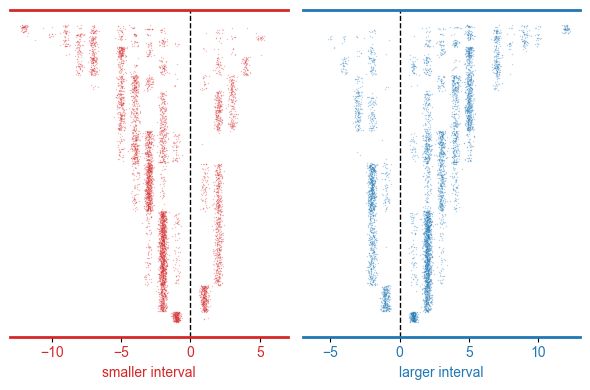

In [7]:
def show_melodic_motif_raster_plot(motifs, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharey=True, tight_layout=True)
    ax1, ax2 = axs
    decorate_raster_plot(ax1, ax2)

    size = np.abs(motifs).sum(axis=1)
    order = np.argsort(size)
    short, long = np.sort(motifs[order, :], axis=1).T

    ys = np.arange(len(short)).astype(float)
    alpha = 1 if len(motifs) < 2000 else .3
    jitter_scatter(short, ys, jitter=.15, alpha=alpha, ax=ax1, c='C3')
    jitter_scatter(long, ys, jitter=.15, alpha=alpha,  ax=ax2, c='C0')
    # ax1.set_xlim(np.quantile(short, .05), np.quantile(short, .95))
    # ax2.set_xlim(np.quantile(long, .05), np.quantile(long, .95))
    ax1.set_xlim(-13, 7)
    ax2.set_xlim(-7, 13)

_, pitches = load_data('creighton-nova-scotia', repeats=False)
motifs = interval_motifs(pitches, 2)
show_melodic_motif_raster_plot(motifs)


In [8]:
for corpus in CORPORA:
    _, pitches = load_data(corpus, repeats=False)
    motifs = interval_motifs(pitches, 2)
    show_melodic_motif_raster_plot(motifs)
    plt.suptitle(corpus)
    if SAVE:
        plt.savefig(f'../figures/melody-raster-plots/melody-raster-plot-{corpus}.pdf')
        plt.close()

## Melody triangles (ternary plots)

### Ternary plotting demo

/Users/bas/repos/papers/melody-squares/env/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


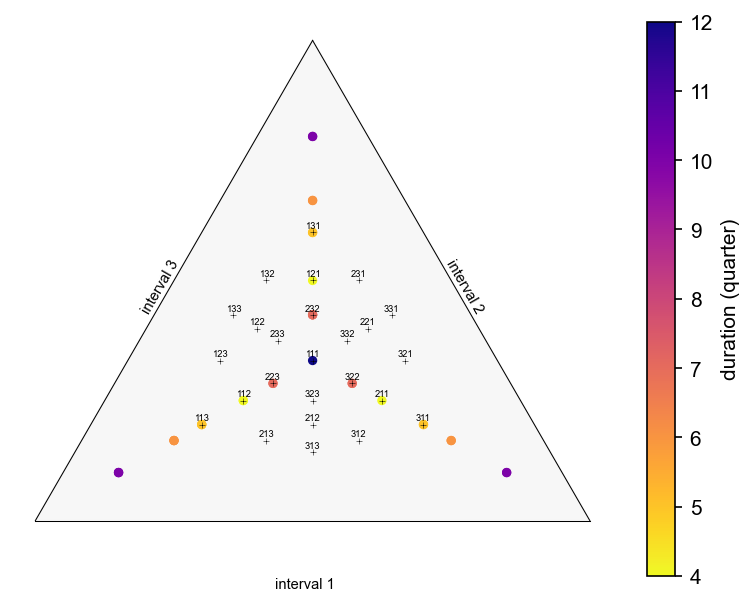

In [9]:
from triangleplots import subset, setup_rhythm_plot, show_integer_ratios, show_triangle_scatter

demo_onsets = [
    np.cumsum([0, 1, 1, 2, 1, 1, 2]),
    np.cumsum([0, 4, 4, 4]),
    np.cumsum([0, 1, 1, 3, 1, 1, 3, 1, 1, 3]),
    np.cumsum([0, 1, 1, 4, 1, 1, 4, 1, 1, 4]),
    np.cumsum([0, 1, 1, 8, 1, 1, 8, 1, 1, 8]),
    np.cumsum([0, 2, 3, 2, 2, 3, 2, 2, 3, 2]),
]
motifs, duration = normalize(interval_motifs(demo_onsets, 3))
show_triangle_scatter(motifs, duration, alpha=1, s=20, min_dur=0.0, max_dur=1.0);

### Plot melody triangles

In [10]:
def pitch_motifs(songs, length=3, normalize=True, sort=False):
    motifs = []
    for song in songs:
        song_motifs = sliding_window(song, length + 1)
        motifs.extend(song_motifs)
    motifs = np.array(motifs)
    if sort:
        motifs.sort(axis=1)
        
    reach = motifs[:, -1] - motifs[:, 0]
    intervals = motifs[:, 1:] - motifs[:, :-1]
    if normalize:
        intervals = intervals / reach[:, np.newaxis]
    return intervals, reach

pitch_motifs([np.array([2, 3, 5, 9]), np.array([5, -6, 7])], length=2)

(array([[ 0.33333333,  0.66666667],
        [ 0.33333333,  0.66666667],
        [-5.5       ,  6.5       ]]),
 array([3, 6, 2]))

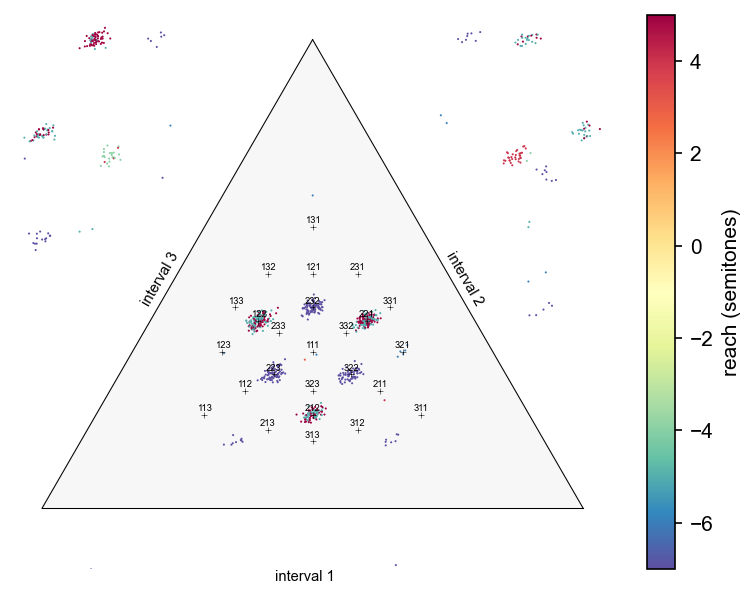

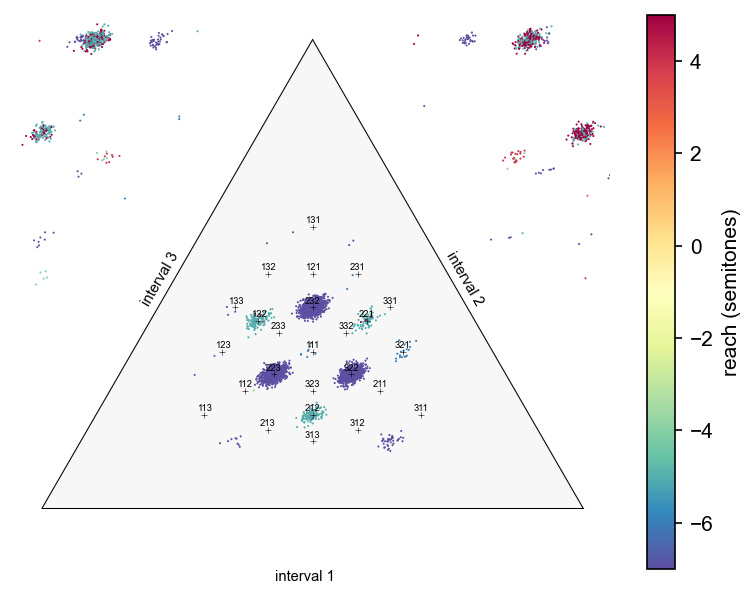

In [11]:
# corpus = 'creighton-nova-scotia'
for corpus in ['creighton-nova-scotia', 'essen-china-han']:
    _, pitches = load_data(corpus, repeats=False)
    motifs, reach = pitch_motifs(pitches, 3, normalize=False)
    non_stationary = reach != 0
    motifs = motifs[non_stationary, :]
    reach = reach[non_stationary]
    motifs = motifs / reach[:, np.newaxis]
    show_triangle_scatter(motifs, reach, jitter=.01, alpha=1, 
        cmap='Spectral_r', colorbar_label='reach (semitones)')
    plt.show() 
        

### Sorted pitches

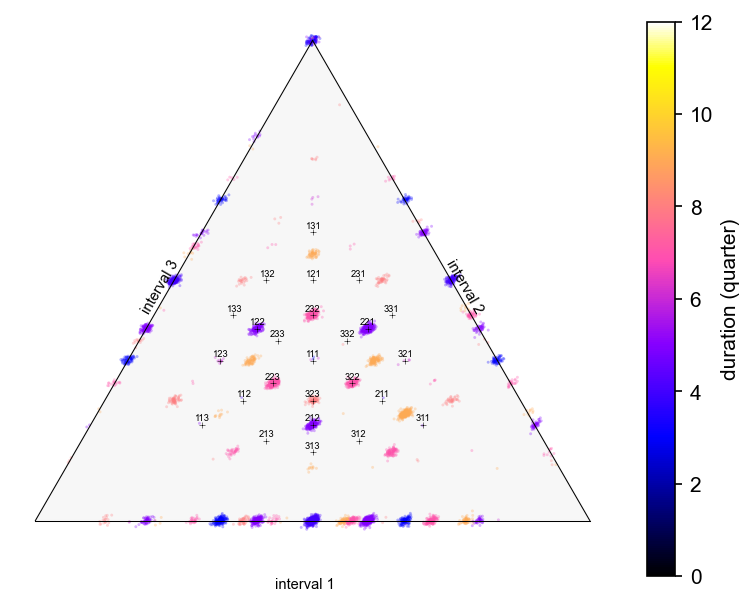

In [12]:
def show_sorted_melodic_motifs(corpus, vmin=0, vmax=12):
    _, pitches = load_data(corpus, repeats=False)
    motifs, ranges = pitch_motifs(pitches, 3, sort=True, normalize=True)
    show_triangle_scatter(motifs, ranges, jitter=.005, s=2, cmap='gnuplot2', vmin=vmin, vmax=vmax)

show_sorted_melodic_motifs('creighton-nova-scotia')

In [13]:
# for corpus in CORPORA:
#     show_sorted_melodic_motifs('creighton-nova-scotia')
#     plt.title(corpus)
#     plt.show()